# **Proiect ML si NN**

# Preprocesarea datelor

Obiectivul: Prezicerea notelor la examen pe target-ul exam_score.

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif


In [137]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/student-habits-and-academic-performance-dataset/enhanced_student_habits_performance_dataset/enhanced_student_habits_performance_dataset.csv


In [138]:

path ="/kaggle/input/student-habits-and-academic-performance-dataset/enhanced_student_habits_performance_dataset/enhanced_student_habits_performance_dataset.csv"
df = pd.read_csv(path)

In [139]:
print(df.shape)
df.head()

(80000, 31)


,student_id,age,gender,major,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,...,screen_time,study_environment,access_to_tutoring,family_income_range,parental_support_level,motivation_level,exam_anxiety_score,learning_style,time_management_score,exam_score
0,100000,26,Male,Computer Science,7.645367,3.0,0.1,Yes,70.3,6.2,...,10.9,Co-Learning Group,Yes,High,9,7,8,Reading,3.0,100
1,100001,28,Male,Arts,5.700000,0.5,0.4,No,88.4,7.2,...,8.3,Co-Learning Group,Yes,Low,7,2,10,Reading,6.0,99
2,100002,17,Male,Arts,2.400000,4.2,0.7,No,82.1,9.2,...,8.0,Library,Yes,High,3,9,6,Kinesthetic,7.6,98
3,100003,27,Other,Psychology,3.400000,4.6,2.3,Yes,79.3,4.2,...,11.7,Co-Learning Group,Yes,Low,5,3,10,Reading,3.2,100
4,100004,25,Female,Business,4.700000,0.8,2.7,Yes,62.9,6.5,...,9.4,Quiet Room,Yes,Medium,9,1,10,Reading,7.1,98


In [140]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     80000 non-null  int64  
 1   age                            80000 non-null  int64  
 2   gender                         80000 non-null  object 
 3   major                          80000 non-null  object 
 4   study_hours_per_day            80000 non-null  float64
 5   social_media_hours             80000 non-null  float64
 6   netflix_hours                  80000 non-null  float64
 7   part_time_job                  80000 non-null  object 
 8   attendance_percentage          80000 non-null  float64
 9   sleep_hours                    80000 non-null  float64
 10  diet_quality                   80000 non-null  object 
 11  exercise_frequency             80000 non-null  int64  
 12  parental_education_level       80000 non-null 

Eliminarea coloanei ID pentru că nu are valoare predictivă, modelul care ar încerca să învețe prin coloana dată ar face asocieri eronate. În unele cazuri poate produce scurgeri de informații prin care să inducă modelul de predicție în eroare și să creeze o corelație falsă care să arate o performanță ridicată sau scăzută a modelului.

In [125]:
TARGET_REG = "exam_score"
TARGET_CLF = "dropout_risk"

id_like = [c for c in df.columns if c.lower().endswith("id")]
df_model = df.drop(columns=id_like)
df_model.head(3)

,age,gender,major,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,...,screen_time,study_environment,access_to_tutoring,family_income_range,parental_support_level,motivation_level,exam_anxiety_score,learning_style,time_management_score,exam_score
0,26,Male,Computer Science,7.645367,3.0,0.1,Yes,70.3,6.2,Poor,...,10.9,Co-Learning Group,Yes,High,9,7,8,Reading,3.0,100
1,28,Male,Arts,5.700000,0.5,0.4,No,88.4,7.2,Good,...,8.3,Co-Learning Group,Yes,Low,7,2,10,Reading,6.0,99
2,17,Male,Arts,2.400000,4.2,0.7,No,82.1,9.2,Good,...,8.0,Library,Yes,High,3,9,6,Kinesthetic,7.6,98


Eliminarea spațiilor din text - Identificarea valorilor lipsă - Eliminarea rândurilor duplicate. În următoare parte s-au creat 3 pasi de procesare:

1. Prin utilizarea metodei .strip(), am eliminat spațiile albe (whitespace) de la începutul și sfârșitul valorilor textuale. Acest lucru este esențial pentru a preveni tratarea aceleiași categorii (ex: "Male " și "Male") ca două entități distincte în timpul procesului de encoding. Se asigură astfel coerența și precizia în reprezentarea variabilelor nominale/ordinale.
2. Modelele matematice nu pot gestiona valorile lipsă, iar al doilea pas verificăm dacă  ele există și le afișăm în formă tabelară.
3. Am eliminat rândurile duplicate (folosind drop_duplicates()). Prezența lor ar fi introdus un bias artificial, supra-reprezentând anumite tipare și mărind riscul de supra-antrenare (overfitting). Prin eliminare, ne asigurăm că modelul învață din observații unice, îmbunătățind capacitatea de generalizare.

In [141]:
import numpy as np
import pandas as pd

for c in df_model.select_dtypes(include="object"):
    df_model[c] = df_model[c].astype(str).str.strip()

na_table = (
    df_model.isna().sum()
    .sort_values(ascending=False)
    .to_frame("missing")
)
display(na_table.head(10))

dup_count = df_model.duplicated().sum()
print("Duplicat exact:", dup_count)
if dup_count>0:
    df_model = df_model.drop_duplicates().reset_index(drop=True)

,missing
age,0
gender,0
time_management_score,0
learning_style,0
exam_anxiety_score,0
motivation_level,0
parental_support_level,0
family_income_range,0
access_to_tutoring,0
study_environment,0


Duplicat exact: 0


Împărțirea datelor previne supraînvățarea (overfitting) și permite validarea performanței modelului pe date nevăzute. Împărțirea setului de date s-a făcut prin următorii pași:

1. Modelul se va antrena pe ”X_train„ și ”y_train”. Apoi, va face predicții pe X_test ,iar acele predicții vor fi comparate cu răspunsurile corecte (y_test) pentru a calcula acuratețea.
2. Variabila ”strat” dezactivează stratificarea care ar fi necesară în cazul clasificării, ea creeaza o flexibilitate în cod, în cazul în care ne decidem să folosim clasificarea.
3. test_size=0.2: Specifică faptul că 20% din date vor fi alocate pentru setul de testare, iar 80% pentru antrenare.

In [128]:
from sklearn.model_selection import train_test_split

TARGET = TARGET_REG  

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

strat = y if y.nunique()<=20 and y.dtype=='object' else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)
X_train.shape, X_test.shape

((64000, 29), (16000, 29))


1. *Pipeline și ColumnTransformer* -  am creat un pipeline care incapsuleaza pasii astfel incat intregul flux de preprocesare devine astfel coerent, automatizat și ușor de reprodus, eliminând erorile manuale.ColumnTransformer acționează ca un director, separând coloanele în fluxuri distincte (numerice și categorice) și asigurând că fiecărui tip de date i se aplică transformarea adecvată.
   
2. *Transformarea Numerică*- Pentru coloanele numerice, am ales RobustScaler deoarece acesta este cel mai rezistent la valorile aberante (outliers). Seturile de date despre studenți pot conține extreme (de exemplu, un număr neobișnuit de mare de ore de Netflix) care, dacă ar fi folosite în metode bazate pe medie, ar distorsiona scalarea. RobustScaler evită această problemă deoarece se bazează pe mediană (valoarea din mijloc) în loc de medie, oferind un punct de referință stabil care nu este influențat de acele valori extreme. Prin urmare, garantăm că scalarea nu va influența excesiv antrenamentul modelului nostru de regresie.

3. *Transformarea Categorică* - Pentru variabilele textuale, am folosit OneHotEncoder (OHE), acesta este esential deoarece transformă fiecare categorie în coloane binare (0 sau 1), evitând ca modelul să presupună o ordine ierarhică greșită între categorii (o eroare comună). Parametrul handle_unknown="ignore" este important pentru prevenirea scurgerii de date (data leakage). Acesta asigură că, dacă în setul de testare (X_test) apare o categorie nouă, neașteptată, aceasta va fi pur și simplu ignorată, simulând corect un scenariu real de producție și prevenind erorile la transformarea datelor noi.

In [129]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
import numpy as np

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

num_pipe = Pipeline(steps=[ 
    ('scaler', RobustScaler()) 
])

cat_pipe = Pipeline([ 
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

Selecția Caracteristicilor
1. Am utilizat Mutual Information (MI) pentru a măsura dependența și relevanța fiecărei caracteristici (X) față de variabila țintă (exam_score). MI este o tehnică de selecție a caracteristicilor care ne ajută să înțelegem ce variabile aduc cea mai mare cantitate de informație unică despre scorul la examen. Cu cât scorul MI este mai mare, cu atât caracteristica respectivă are o putere predictivă mai mare.
 
2. Calculul se bazează pe datele deja transformate (X\_prep). Am aplicat întregul Pipeline de preprocesare (preprocess\_1.fit\_transform(X\_train)) pe datele de atrenament. Acest lucru a fost necesar pentru a obține un set de date numeric și scalat pe care funcția mutual_info_regression să poată lucra. Am folosit random_state=42 doar pentru a asigura reproductibilitatea rezultatului MI.

3. Tabelul mi_df ne oferă un clasament al celor mai bune caracteristici predictive. Confirmăm că previous_gpa este cel mai puternic predictor (scorul MI cel mai mare), urmat de factori de studiu precum study_hours_per_day și motivation_level.

In [142]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
import pandas as pd
import numpy as np

is_classification = (TARGET == TARGET_CLF)
mi_func = mutual_info_classif if is_classification else mutual_info_regression

X_sample = X_train 
y_sample = y_train  

X_prep = preprocess.fit_transform(X_sample)

mi_scores = mi_func(X_prep, y_sample, random_state=42)

ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) > 0 else np.array([])
feature_names = np.r_[num_cols, cat_names]

mi_df = pd.DataFrame({
    "Feature": feature_names,
    "MI_Score": mi_scores
}).sort_values("MI_Score", ascending=False)

mi_df.head(15)

,Feature,MI_Score
8,previous_gpa,0.809994
14,motivation_level,0.038190
1,study_hours_per_day,0.029438
15,exam_anxiety_score,0.023296
12,screen_time,0.016972
45,study_environment_Dorm,0.010528
49,access_to_tutoring_Yes,0.007974
48,access_to_tutoring_No,0.007537
2,social_media_hours,0.007329
5,sleep_hours,0.006705


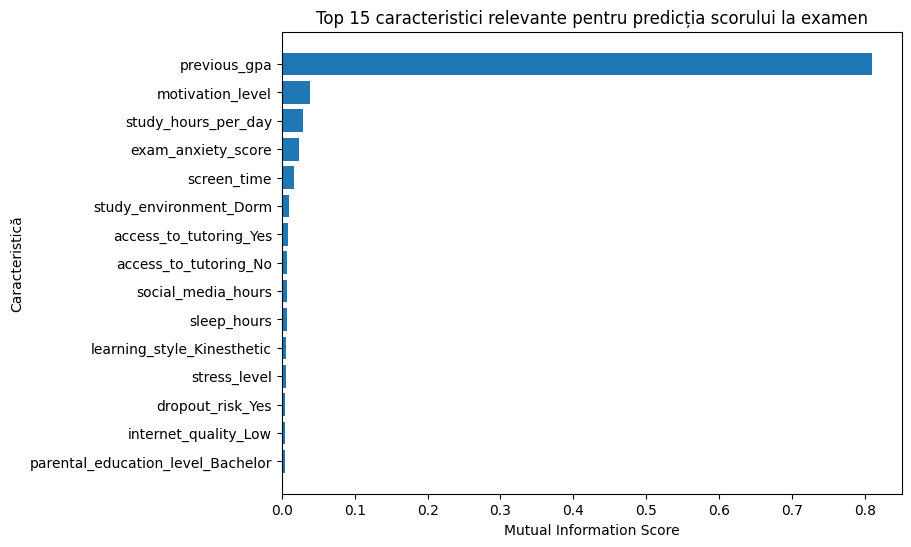

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(mi_df['Feature'].head(15)[::-1], mi_df['MI_Score'].head(15)[::-1])
plt.xlabel("Mutual Information Score")
plt.ylabel("Caracteristică")
plt.title("Top 15 caracteristici relevante pentru predicția scorului la examen")
plt.show()

Testarea preprocesarii printr-un model Ridge Regression

Crearea variabilei ”selector” care este învață să găsească automat cele mai bune k (50) caracteristici folosind funcția de scorare ”mi_func”.
Întregul proces (preprocesare, selecție, regresie) este conținut într-un singur obiect ”model_topk”. Acest lucru previne erorile umane și scurgerile de date (data leakage). Elementul ”alpha=1.0” din Ridge are grijă ca modelul să selecteze valori care nu ar necesita resurse prea mari de procesare prin asta eliminând șansa de overfitting.
După antrenarea fluxului creat ”model_topk” se vor face predicții pe datele de testare.
Scorurile R² și MAE afișate reprezintă performanța acestui model optimizat.

In [132]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

mi_func = mutual_info_regression
k = 20
selector = SelectKBest(score_func=mi_func, k=k)

model_topk = Pipeline([
    ("preprocess", preprocess),
    ("select", selector),
    ("regressor", Ridge(alpha=1.0))
])

model_topk.fit(X_train, y_train)
y_pred = model_topk.predict(X_test)

print("R² (Top-20):", r2_score(y_test, y_pred))
print("MAE (Top-20):", mean_absolute_error(y_test, y_pred))

R² (Top-20): 0.8704592870967346
MAE (Top-20): 3.1964686525982513


Scopul principal al acestui pas este validarea stabilității și a capacității de generalizare a modelului. Prin compararea metricii R2 (Coeficientul de Determinație) între setul de antrenament X_train și setul de testare X_test, putem detecta probleme de supra-antrenare (overfitting) sau sub-antrenare (underfitting).
Faptul că scorurile sunt practic identice demonstrează că modelul nu a supra-învățat (overfit) pe datele de antrenament. Performanța pe datele nevăzute este aceeași cu performanța pe datele văzute. Această stabilitate este un semn că setul de date a fost preprocesat corect (fără data leakage).

In [16]:
y_pred_test = model_topk.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"R² Test: {r2_test:.4f}")

y_pred_train = model_topk.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"R² Train: {r2_train:.4f}")

R² Test: 0.8705
R² Train: 0.8704


# Studierea cazului în care se face antrenarea și testarea setului de test fără caracteristica previous_gpa

În cele ce urmează am mers pe calea de a elimina caracteristica previous_gpa din setul de date. În urma preprocesării cu prezența gpa R2 a oferit o valoare foarte bună ceea ce indică că procesul de antrenare se bazează cel mai mult pe o singură caracteristică previous_gpa și vrem să aflăm dacă se poate de făcut antranarea modelului pe datele rămase.

Pe langa id am eliminat si previous_gpa pentru a urmări cum se schimbă R2 pentru celelalte date rămase în dataset.

In [67]:
TARGET_REG = "exam_score"
TARGET_CLF = "dropout_risk"

id_like_1 = [c for c in df.columns if c.lower().endswith("id")]
cols_to_drop_1 = id_like_1 + ['previous_gpa'] 
df_underfitting = df.drop(columns=cols_to_drop_1)

df_underfitting.head(3)

,age,gender,major,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,...,screen_time,study_environment,access_to_tutoring,family_income_range,parental_support_level,motivation_level,exam_anxiety_score,learning_style,time_management_score,exam_score
0,26,Male,Computer Science,7.645367,3.0,0.1,Yes,70.3,6.2,Poor,...,10.9,Co-Learning Group,Yes,High,9,7,8,Reading,3.0,100
1,28,Male,Arts,5.700000,0.5,0.4,No,88.4,7.2,Good,...,8.3,Co-Learning Group,Yes,Low,7,2,10,Reading,6.0,99
2,17,Male,Arts,2.400000,4.2,0.7,No,82.1,9.2,Good,...,8.0,Library,Yes,High,3,9,6,Kinesthetic,7.6,98


In [68]:
import numpy as np
import pandas as pd

for c in df_underfitting.select_dtypes(include="object"):
    df_underfitting[c] = df_underfitting[c].astype(str).str.strip()

na_table_1 = (
    df_underfitting.isna().sum()
    .sort_values(ascending=False)
    .to_frame("missing")
)
display(na_table_1.head(10))

dup_count_1 = df_underfitting.duplicated().sum()
print("Duplicat exact:", dup_count_1)
if dup_count_1>0:
    df_underfitting = df_underfitting.drop_duplicates().reset_index(drop=True)

,missing
age,0
semester,0
time_management_score,0
learning_style,0
exam_anxiety_score,0
motivation_level,0
parental_support_level,0
family_income_range,0
access_to_tutoring,0
study_environment,0


Duplicat exact: 0


In [146]:
from sklearn.model_selection import train_test_split

TARGET = TARGET_REG  

X_1 = df_underfitting.drop(columns=[TARGET])
y_1 = df_underfitting[TARGET]

strat_1 = y if y_1.nunique()<=20 and y_1.dtype=='object' else None

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_1, y_1, test_size=0.2, random_state=42, stratify=strat_1
)
X_train_1.shape, X_test_1.shape

((64000, 28), (16000, 28))

In [148]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import numpy as np

num_cols_1 = X_train_1.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_1 = [c for c in X_train_1.columns if c not in num_cols_1]

num_pipe_1 = Pipeline(steps=[ 
    ('scaler', RobustScaler()) 
])

cat_pipe_1 = Pipeline([ 
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_1 = ColumnTransformer(
    transformers=[
        ('num', num_pipe_1, num_cols_1),  
        ('cat', cat_pipe_1, cat_cols_1)               
    ])

In [149]:

from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
import pandas as pd
import numpy as np

is_classification_1 = (TARGET == TARGET_CLF)
mi_func_1 = mutual_info_classif if is_classification_1 else mutual_info_regression

X_sample_1 = X_train_1 
y_sample_1 = y_train_1

X_prep_1 = preprocess_1.fit_transform(X_sample_1)

mi_scores_1 = mi_func_1(X_prep_1, y_sample_1, random_state=42)

ohe_1 = preprocess_1.named_transformers_["cat"].named_steps["onehot"]
cat_names_1 = ohe_1.get_feature_names_out(cat_cols_1) if len(cat_cols_1) > 0 else np.array([])
feature_names_1 = np.r_[num_cols_1, cat_names_1]

mi_df_1 = pd.DataFrame({
    "Feature": feature_names_1,
    "MI_Score": mi_scores_1
}).sort_values("MI_Score", ascending=False)

mi_df_1.head(15)

,Feature,MI_Score
13,motivation_level,0.037359
14,exam_anxiety_score,0.034718
1,study_hours_per_day,0.034090
11,screen_time,0.013407
44,study_environment_Dorm,0.011149
47,access_to_tutoring_No,0.010046
46,study_environment_Quiet Room,0.008786
48,access_to_tutoring_Yes,0.007828
40,dropout_risk_No,0.007554
36,internet_quality_Low,0.005341


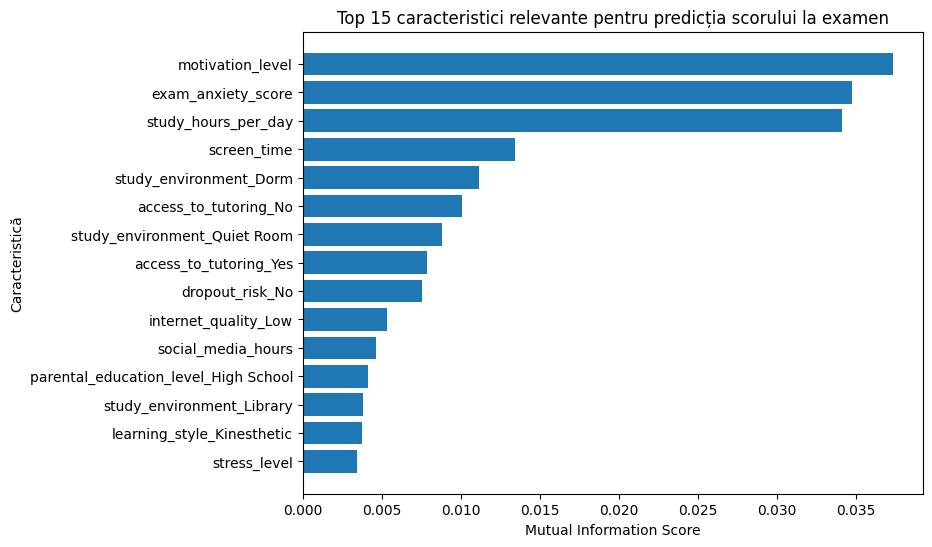

In [150]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(mi_df_1['Feature'].head(15)[::-1], mi_df_1['MI_Score'].head(15)[::-1])
plt.xlabel("Mutual Information Score")
plt.ylabel("Caracteristică")
plt.title("Top 15 caracteristici relevante pentru predicția scorului la examen")
plt.show()

In [151]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

mi_func_1 = mutual_info_regression
k_1 = 50
selector_1 = SelectKBest(score_func=mi_func_1, k=k_1)

model_topk_1 = Pipeline([
    ("preprocess", preprocess_1),
    ("select", selector_1),
    ("regressor", Ridge(alpha=1.0))
])

model_topk_1.fit(X_train_1, y_train_1)
y_pred_1 = model_topk_1.predict(X_test_1)

print("R² (Top-20):", r2_score(y_test_1, y_pred_1))
print("MAE (Top-20):", mean_absolute_error(y_test_1, y_pred_1))

R² (Top-20): 0.1944052239516163
MAE (Top-20): 8.572735385328583


Rezultatul comparării X_test_1 și X_train_1 sugerează că R2 este de o diferență mică între cele două, însă valoare de 0.1944 pentru R2 de mai sus evidențiază că modelul dat este underfitting. Pentru ca să se poate lucra mai departe cu aceste date ar trebui să adăugăm date în plus pentru componenetele respective ca să aibă putere de prezicere mai mare asupra obiectivului propus.

In [74]:
y_pred_test_1 = model_topk_1.predict(X_test_1)
r2_test_1 = r2_score(y_test_1, y_pred_test_1)
print(f"R² Test: {r2_test_1:.4f}")

y_pred_train_1 = model_topk_1.predict(X_train_1)
r2_train_1 = r2_score(y_train_1, y_pred_train_1)
print(f"R² Train: {r2_train_1:.4f}")

R² Test: 0.1947
R² Train: 0.1942


**Concluzie**: Obiectivul de a prezice exam_score folosind doar variabile de stil de viață este un eșec. Obiceiurile de viață ale unui student (ore de somn, ore pe Netflix, ore pe social media, dietă) nu au aproape nicio putere de a prezice nota exactă pe care o va lua la un examen. Pe baza datelor pe care le-am folositnu se pot face predicții. Aceste variabile nu au legătură cu ținta.

**În cele ce urmează modelele de ML și NN vor fi create cu ajutorul datelor din primul data set unde este prezent previous_gpa. Nu putem să mergem pe cazul doi din cauză că nu avem îndeajuns informații pentru a afla valoarea la examen pe baza comportamentului studentului. Pentru ca să folosim celelelalte date ar trebui să modificăm obiectivul lucrării și să modificăm și ținta aleasă.**

# Analiza exploratorie a datelor

Histograma afișează care este numărul de studenți pe fiecare scor de la examen. Numărul de studenți fiind frecvența, iar scor examen deja variabila țintă.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


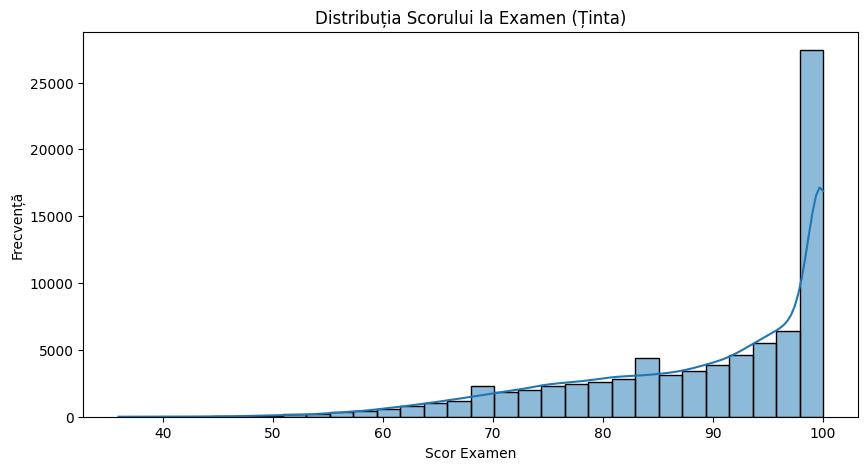

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(df['exam_score'], kde=True, bins=30)
plt.title('Distribuția Scorului la Examen (Ținta)')
plt.xlabel('Scor Examen')
plt.ylabel('Frecvență')
plt.show()

Cele două histograme confirmă că previous_gpa are o distribuție similară cu exam_score, și asimentria puternică la stânga pe care o prezintă ambele grafice confirmă datele din mutual information MI care a confirmat ca prevoius_gpa este cel mai bun predictor pentru exam_score.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


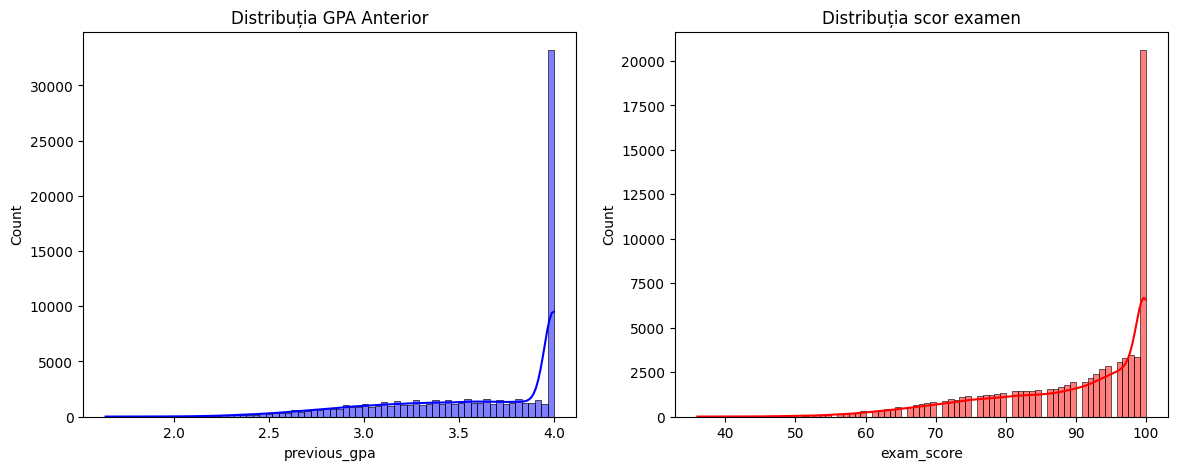

In [30]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))
sns.histplot(df['previous_gpa'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribuția GPA Anterior')
sns.histplot(df['exam_score'], kde=True, ax=axes[1], color='red')
axes[1].set_title('Distribuția scor examen')
plt.show()

Skaterploturile au fost alese pentru a compara variabile numerice cu numerice. Practic din analiza cu MI am extras valorile numerice și le-am comparat direct vizual cu exam_score.


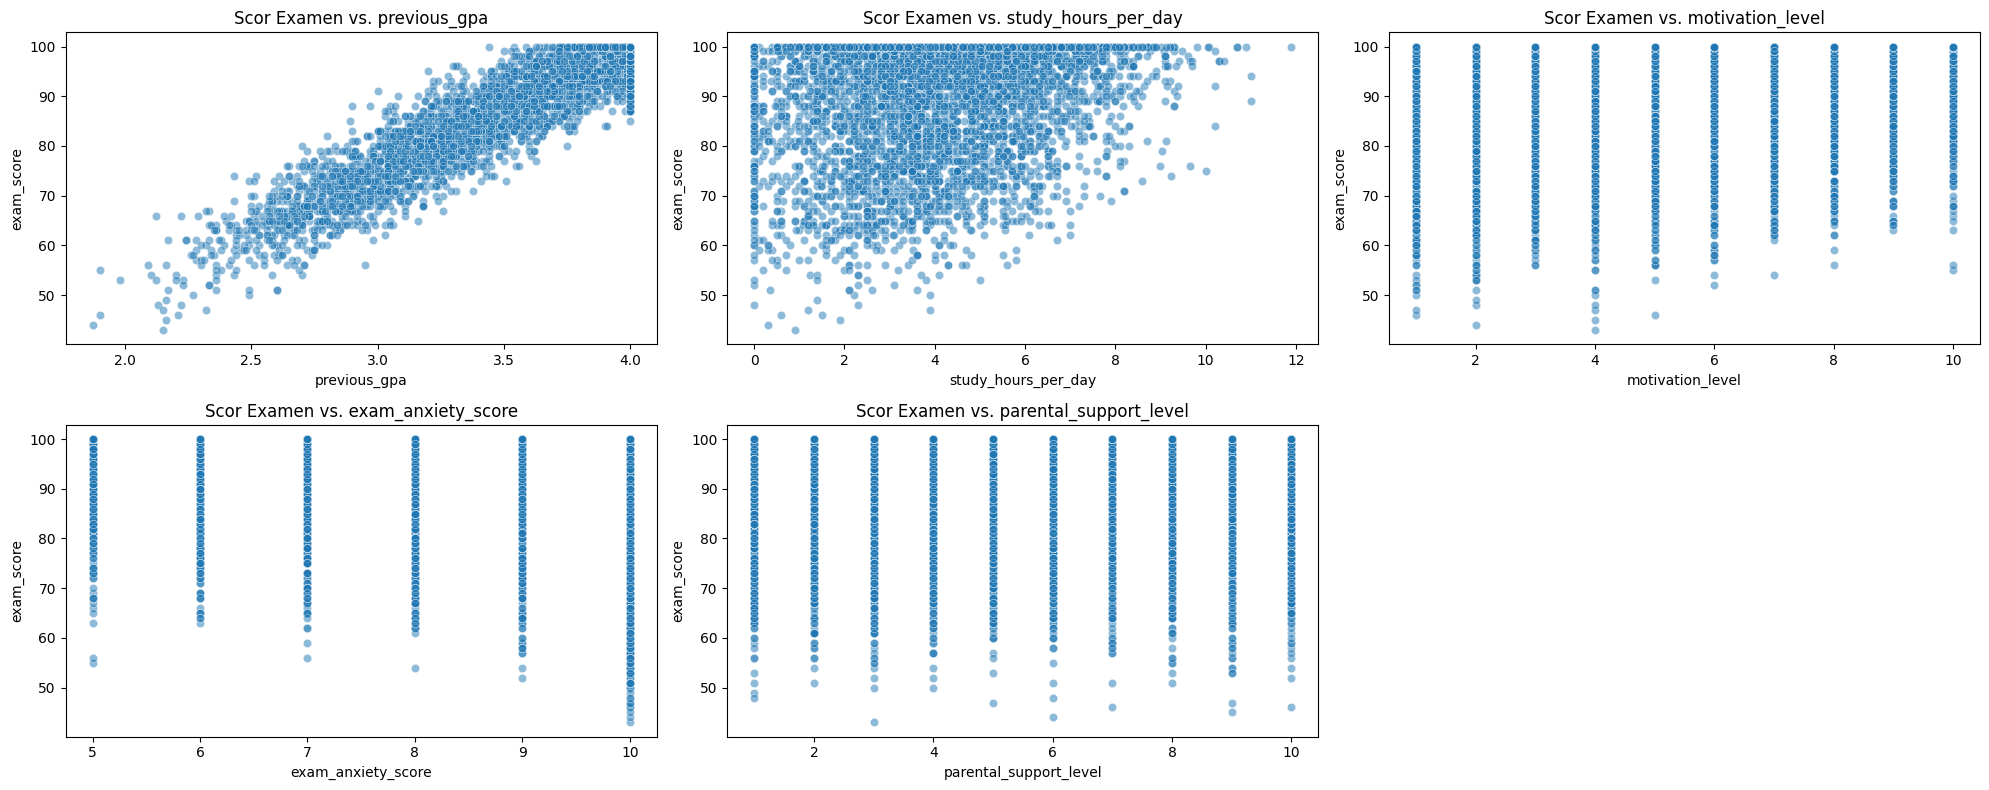

In [31]:
num_features_mi = ['previous_gpa', 'study_hours_per_day', 'motivation_level', 'exam_anxiety_score', 'parental_support_level']
target_col = 'exam_score'

plt.figure(figsize=(20, 8))
for i, col in enumerate(num_features_mi, 1):
    plt.subplot(2, 3, i)
    
    sns.scatterplot(data=df_model.sample(5000, random_state=42), x=col, y=target_col, alpha=0.5)
    plt.title(f'Scor Examen vs. {col}')
    plt.xlabel(col)
    plt.ylabel(target_col)

plt.tight_layout()
plt.savefig('scatter_plots_mi.png')
plt.show()

Cu ajutorul boxplot-urilor de mai jos putem să identificăm valorile aberente care sunt pentru caracteristicele numerice studiate deja.
Orice punct de date care se află în afara ”mustăților„ este considerat o valoare aberantă (outlier) și este desenat ca o "bulină" individuală.

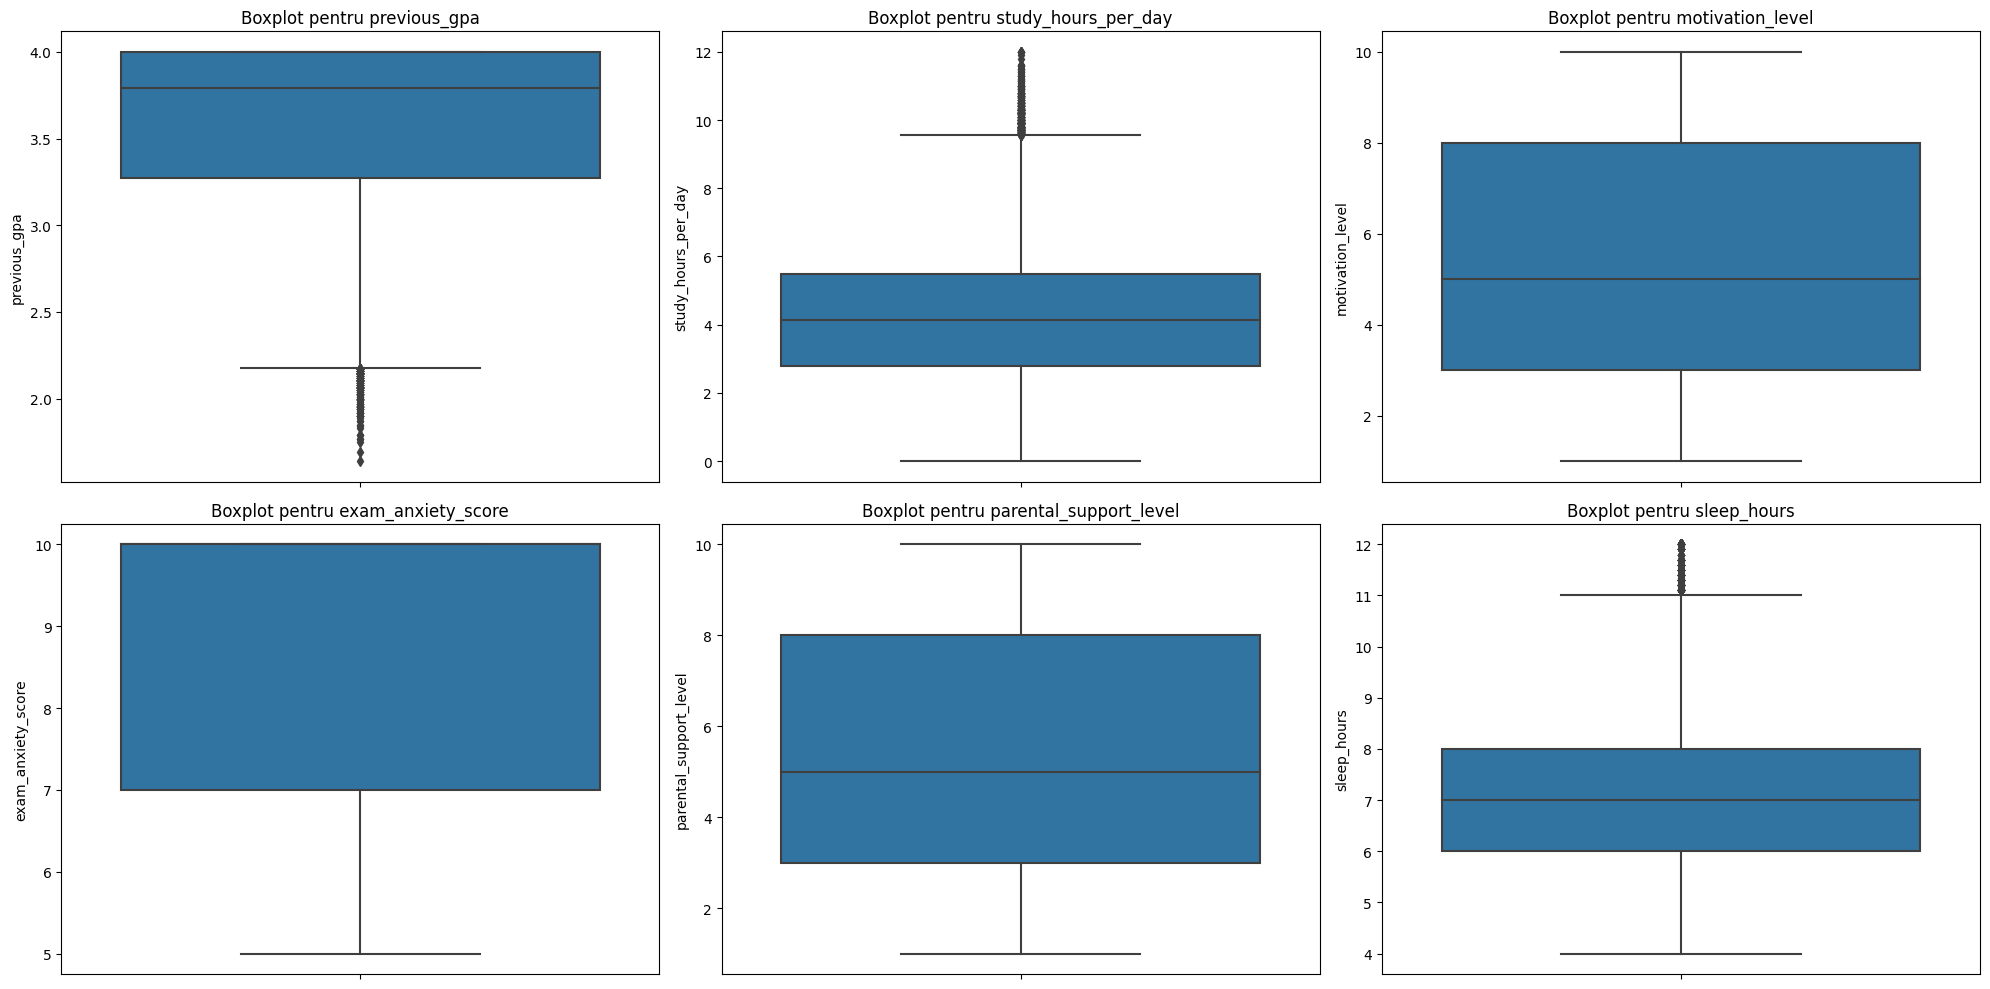

In [32]:
features_to_plot = ['previous_gpa',  'study_hours_per_day',  'motivation_level',  'exam_anxiety_score',  'parental_support_level', 'sleep_hours' ]

plt.figure(figsize=(20, 10))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_model[col])
    plt.title(f'Boxplot pentru {col}')

plt.tight_layout()
plt.show()

Relația dintre previous_gpa și exam_score este una puternică. Prin graficele afișate putem să observăm că prin utilizarea caracteristicii previous_gpa în cadrul modelului de regresie, acesta va fi direct influențat de prezența acesteia. După eliminarea previous_gpa celelaltele elemente par mult mai omogene, însă valoarea acestora este foarte mică ceea ce semnifică că exam_score nu poate fi influențat de către celelalte variabile și va fi complicat să determinăm nota la viitorul examen. Nu poate explica de ce un student care studiază 4 ore ia o notă mai mică decât unul care studiază 2. Există mulți alți factori care influențează scorul.

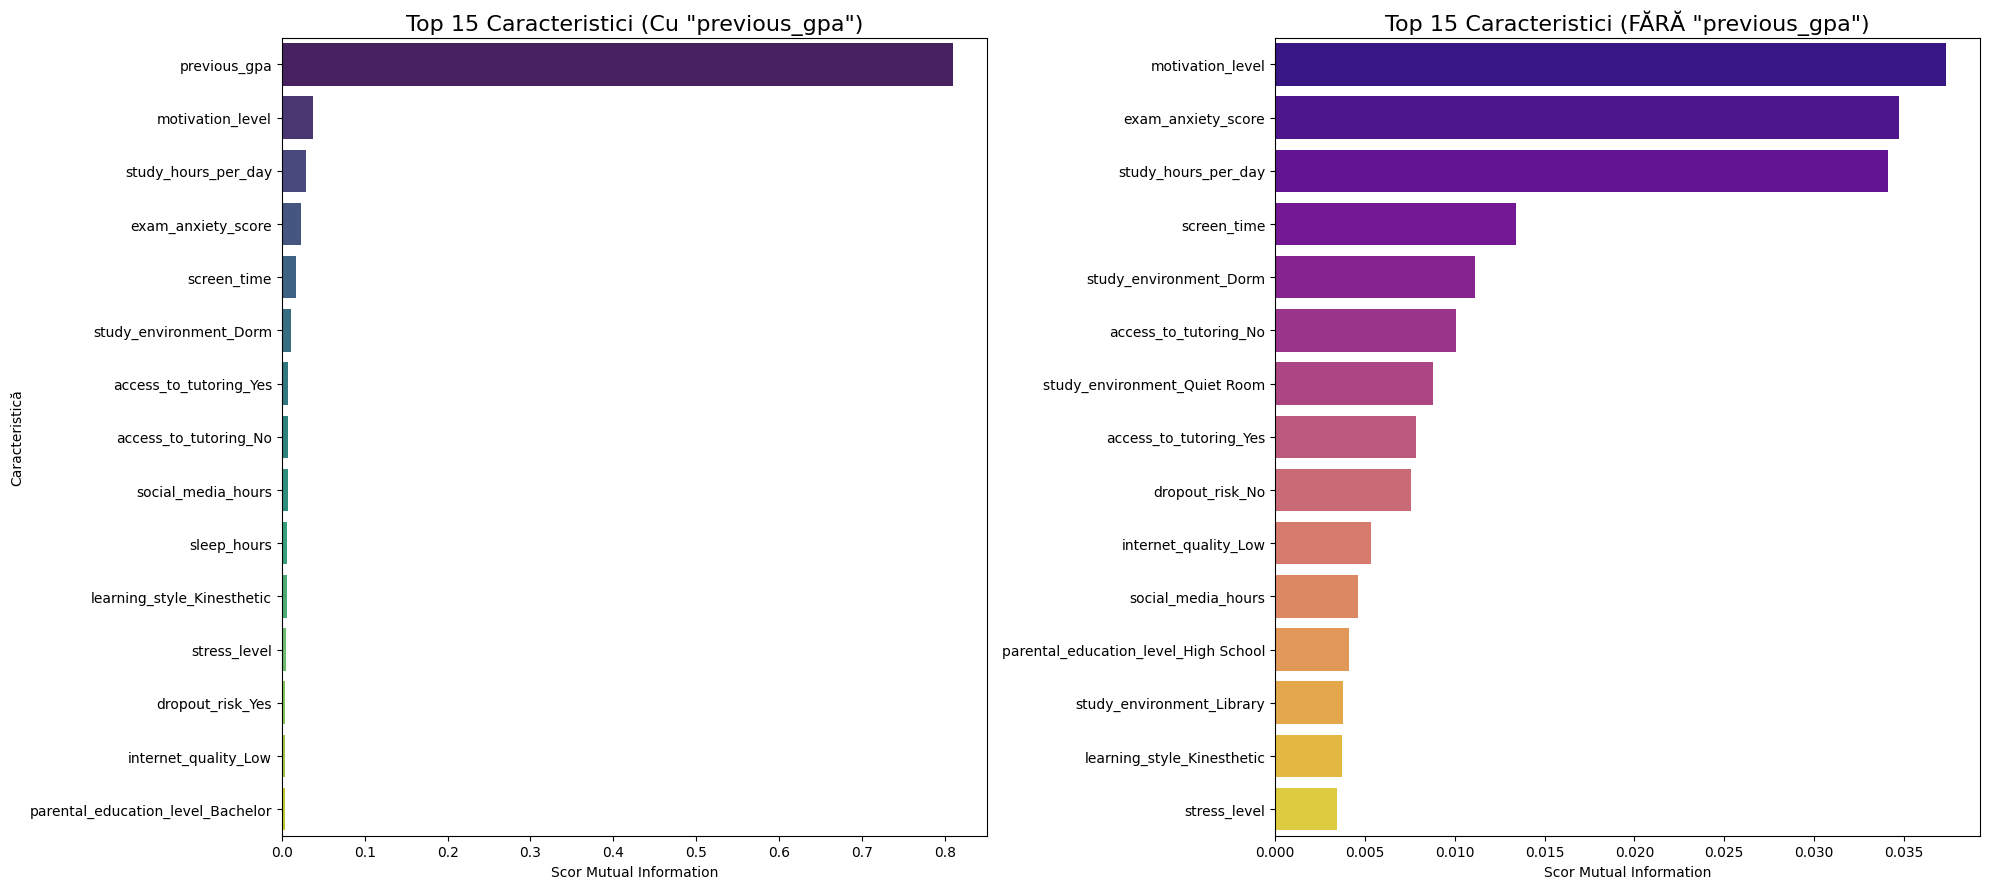

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

sns.barplot(data=mi_df.head(15), x="MI_Score", y="Feature", ax=axes[0], palette="viridis")
axes[0].set_title('Top 15 Caracteristici (Cu "previous_gpa")', fontsize=16)
axes[0].set_xlabel("Scor Mutual Information")
axes[0].set_ylabel("Caracteristică")

sns.barplot(data=mi_df_1.head(15), x="MI_Score", y="Feature", ax=axes[1], palette="plasma")
axes[1].set_title('Top 15 Caracteristici (FĂRĂ "previous_gpa")', fontsize=16)
axes[1].set_xlabel("Scor Mutual Information")
axes[1].set_ylabel("") 

plt.tight_layout()
plt.show()

Linia de regresie definește clar că motivație mai mare = notă mai mare, însă punctele sunt mult mai împrăștiate. Pe lângă aceasta punctele pentru orice nivel de motivatie sunt prezente aproape la toate notele de la examen, valorile sunt prea împrățtiate, ceea ce confirmă de ce este un predictor mult mai "slab" decât previous_gpa și explică performanța mult mai scăzută a modelului 2.

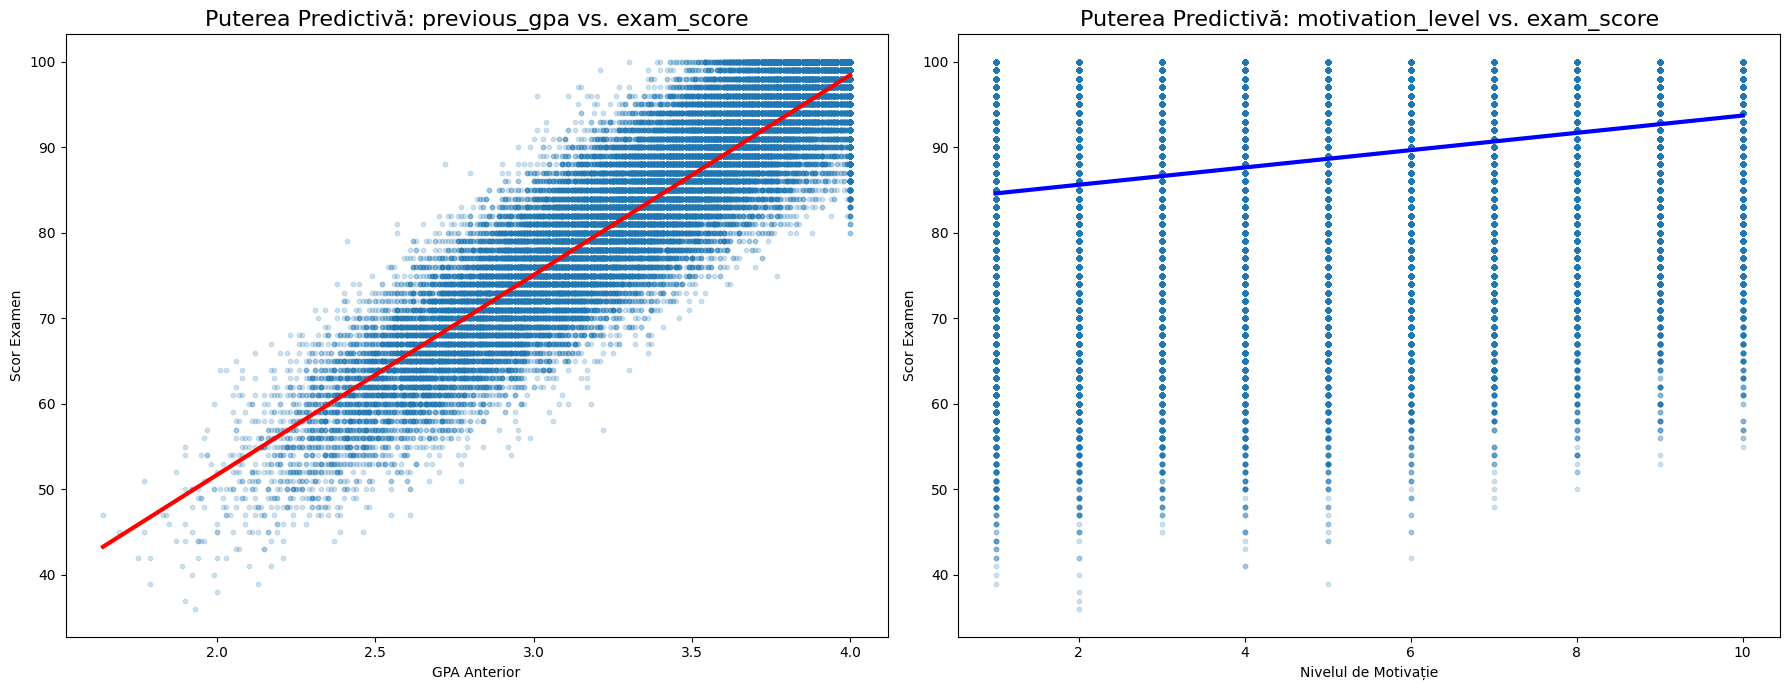

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.regplot(data=df_model, x='previous_gpa', y='exam_score', ax=axes[0],
            scatter_kws={'alpha':0.2, 's': 10}, line_kws={'color':'red', 'lw': 3})
axes[0].set_title('Puterea Predictivă: previous_gpa vs. exam_score', fontsize=16)
axes[0].set_xlabel('GPA Anterior')
axes[0].set_ylabel('Scor Examen')


sns.regplot(data=df_underfitting, x='motivation_level', y='exam_score', ax=axes[1],
            scatter_kws={'alpha':0.2, 's': 10}, line_kws={'color':'blue', 'lw': 3})
axes[1].set_title('Puterea Predictivă: motivation_level vs. exam_score', fontsize=16)
axes[1].set_xlabel('Nivelul de Motivație')
axes[1].set_ylabel('Scor Examen')

plt.tight_layout()
plt.show()

Anterior deja am aflat r2 pentru fiecare model, am reușit să creăm un model grafic care să afișeze diferența dntre valorile celor două modele cu previous_gpa și fără el. Diferența primordială este că prezicerea următoarei note la examen va fi determinată de către modelul 1 unde este previous_gpa, deoarece modelul 2 este mai bun în prezicerea comportamentului studentului decât prezicerea viitoare note la examen.

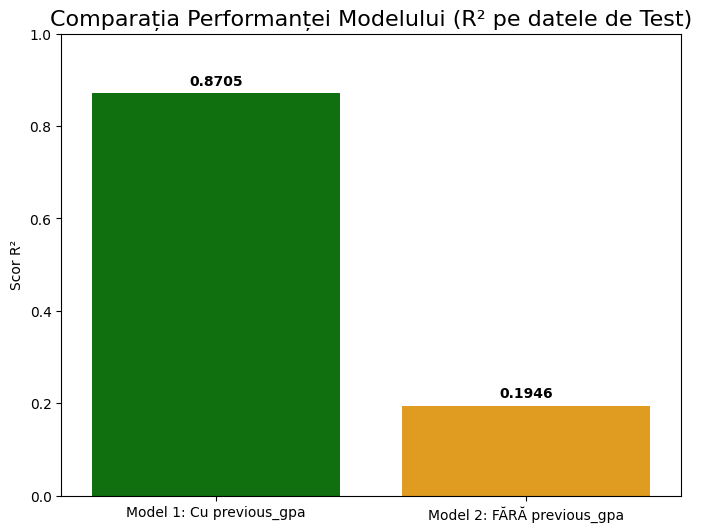

In [35]:
performance_data = {
    'Model': ['Model 1: Cu previous_gpa', 'Model 2: FĂRĂ previous_gpa'],
    'R² Score': [r2_test, r2_test_1]
}
df_perf = pd.DataFrame(performance_data)

plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=df_perf, x='Model', y='R² Score', palette=['green', 'orange'])
plt.title('Comparația Performanței Modelului (R² pe datele de Test)', fontsize=16)
plt.ylabel('Scor R²')
plt.xlabel('')
plt.ylim(0, 1.0)

for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.4f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontweight='bold')

plt.show()

Cu ajutorul functiei ”corr()” se calculeaza coeficientul de corelație care în funcție de calculul acesta poate să fie unul negativ sau pozitiv, spre exemplu:
Pozitivă: previous_gpa (+0.93).Arată că performanța academică anterioară este, cel mai puternic predictor al performanței actuale.
Negativă: exam_anxiety_score (-0.24). Cu cât scorul de anxietate la examen crește, scorul la examen tinde să scadă.
După eliminarea caracteristicii previous_gpa, în graficul din dreapta putem observa că nu mai există foarte multe valori care să aibă o corelație strânsă între ele și exam_score.

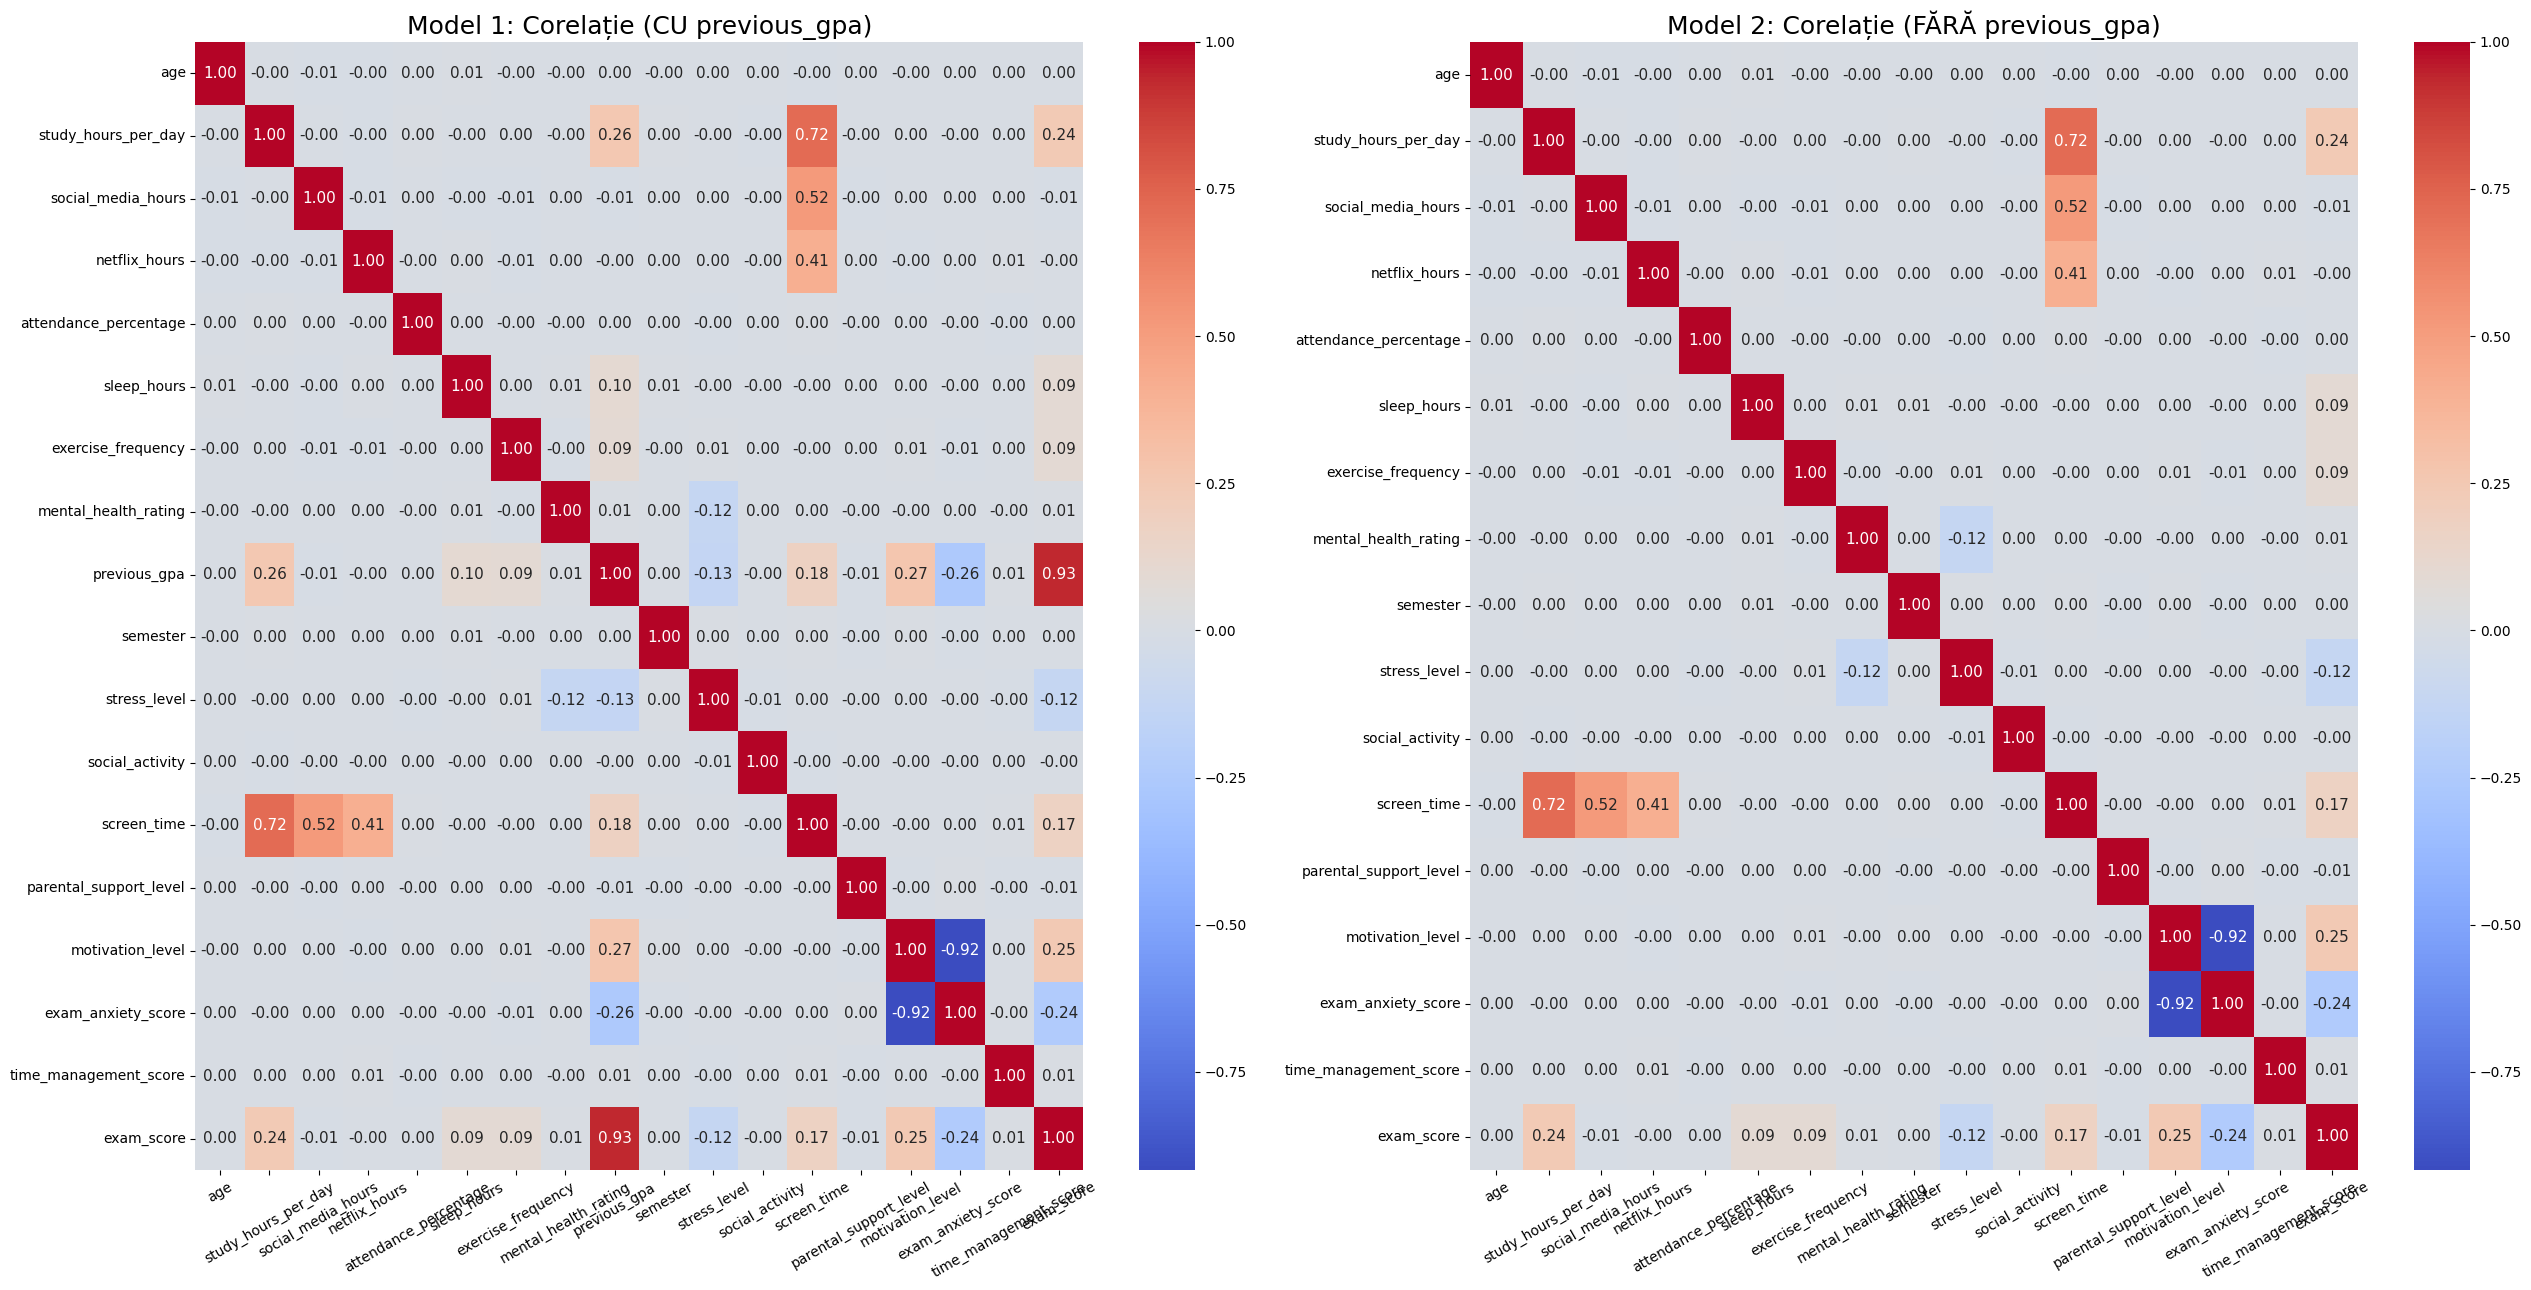

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(26, 13))

num_df_model = df_model.select_dtypes(include=[np.number])
corr_model = num_df_model.corr()

sns.heatmap(corr_model, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0], annot_kws={"size": 11})
axes[0].set_title('Model 1: Corelație (CU previous_gpa)', fontsize=18)
axes[0].tick_params(axis='x', rotation=30)
axes[0].tick_params(axis='y', rotation=0)

num_df_underfitting = df_underfitting.select_dtypes(include=[np.number])
corr_underfitting = num_df_underfitting.corr()

sns.heatmap(corr_underfitting, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1], annot_kws={"size": 11})
axes[1].set_title('Model 2: Corelație (FĂRĂ previous_gpa)', fontsize=18)
axes[1].tick_params(axis='x', rotation=30)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig("comparative_correlation_heatmaps.png")
plt.show()

***Studenta: Dobrovat Diana***
# Invatare supervizata ML - Random Forest Regression

Pentru etapa de învățare supervizată am ales modelul Random Forest deoarece este o metodă foarte stabilă și eficientă atunci când avem multe variabile și relații complexe între ele. În contextul acestui proiect, încercăm să prezicem exam_score pe baza comportamentelor și obiceiurilor studenților. Acest model este potrivit pentru că poate surprinde ușor interacțiunile dintre factori precum somnul, orele de studiu, motivația sau anxietatea.
Pentru implementarea acestui model am folosit un Pipeline pentru a lega împreună preprocesarea (imputare, codificare, scalare) cu modelul Random Forest. 

Pentru flexibilitate am ales 'max_depth=None' care permite arborilor să crească până când datele sunt pur antrenate. Deși crește riscul de overfitting, RF îl temperează prin natura sa de ansamblu.
'min_samples_split=4' a fost folosit pentru a impune ca un nod al unui arbore să fie împărțit doar dacă conține cel puțin 4 mostre (studenți). Aceasta este o formă de regularizare care oprește arborii să învețe zgomotul din date, îmbunătățind generalizarea.


Am ales sa continui cazul in care am caracteristica previous_gpa, chiar daca ea are o putere mare de predictie (aproximativ 80%) in construirea modelelelor fata de celelate caracteristici care au o putere mai mica de predictie (aproximativ 20%), deoarece am dorit sa arat comportamentul modelelor intr-un caz de invatare foarte buna dar care nu este overfitting (pentru ca valoarea train-ului este aproximativ egala cu valoarea testului, ceea ce il face mai degraba un model ideal dupa folosirea unui model liniar ca Ridge).

Fara  caracteristica previous_gpa puterea de predictie e mica, asa cum am spus si demonstrat mai sus, ceea ce punea in evidenta un caz de underfitting, adica modelele ar fi aproape inutile.

In [152]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

rf_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_split=4,
        n_jobs=-1,
        random_state=42
    ))
])

rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

print(" R²:", r2_score(y_test, y_pred))
print(" MAE:", mean_absolute_error(y_test, y_pred))

 R²: 0.8694853542590842
 MAE: 3.2927927702074022


In [153]:
from sklearn.metrics import r2_score, mean_absolute_error


y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)


print("TRAIN R²:", r2_score(y_train, y_pred_train))
print("TRAIN MAE:", mean_absolute_error(y_train, y_pred_train))

print("TEST R²:", r2_score(y_test, y_pred_test))
print("TEST MAE:", mean_absolute_error(y_test, y_pred_test))


TRAIN R²: 0.9790626206651536
TRAIN MAE: 1.2956542736085146
TEST R²: 0.8694853542590842
TEST MAE: 3.2927927702074022


**Testul de mai sus arata ca Random Forest a scos in evidenta, ceea ce  nu a reusit un model de ML liniar simplu  (Ridge), faptul ca este overfitting fiind o diferenta considerabila intre valuarea de train  si  valoare de test a R^2 si MAE**

**Grafic – valori reale vs. valori prezise**

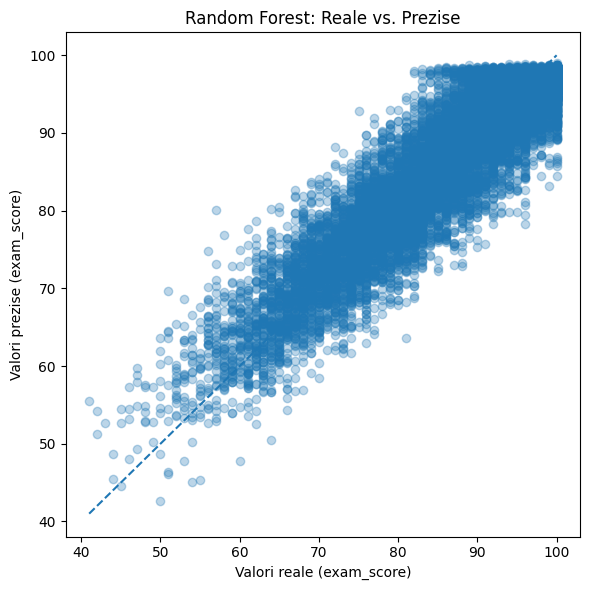

In [154]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--")  
plt.xlabel("Valori reale (exam_score)")
plt.ylabel("Valori prezise (exam_score)")
plt.title("Random Forest: Reale vs. Prezise")
plt.tight_layout()
plt.show()

Graficul Reale vs. Prezise arată o corelație aproape perfectă între valorile reale ale exam_score și predicțiile modelului. Majoritatea punctelor se aliniază de-a lungul diagonalei, indicând că Random Forest reușește să aproximeze foarte precis rezultatele reale.

**Reziduuri**

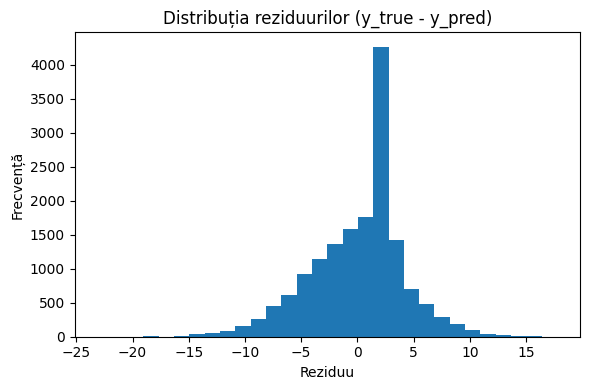

In [155]:
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Distribuția reziduurilor (y_true - y_pred)")
plt.xlabel("Reziduu"); plt.ylabel("Frecvență")
plt.tight_layout()
plt.show()

Histograma reziduurilor  demonstrează că modelul Random Forest Regressor este valid din punct de vedere statistic și foarte precis. El nu are erori sistematice, iar erorile sale sunt mici și aleatorii, avand vârful curbei  situat aproape la zero pe axa reziduurilor

**Cross-validation (5-fold)**

Am folosit cross-validation în 5 folduri pentru a verifica dacă modelul Random Forest este stabil și dacă performanța lui nu depinde întâmplător de modul în care am împărțit datele în train și test.

In [156]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = cross_val_score(rf_reg, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
print("CV MAE (mean ± std):", -cv_mae.mean(), "±", cv_mae.std())

CV MAE (mean ± std): 3.2907825834307616 ± 0.01577714015613701


Rezultatele Cross-Validation pe ambele metrici (R^2și MAE) demonstrează o stabilitate excepțională a modelului. Deviațiile standard minime (aproape zero) confirmă că modelul Random Forest este imun la variațiile minore din datele de antrenament și că performanța sa (o eroare de doar approx 3.29 puncte) este de încredere și va fi menținută și pe date noi.

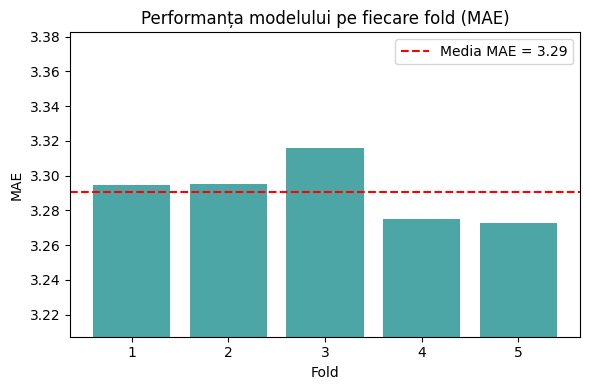

In [157]:
import matplotlib.pyplot as plt
import numpy as np

mae_scores = -cv_mae  

plt.figure(figsize=(6,4))
plt.bar(range(1, len(mae_scores)+1), mae_scores, color='teal', alpha=0.7)
plt.title("Performanța modelului pe fiecare fold (MAE)")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.ylim(min(mae_scores)*0.98, max(mae_scores)*1.02)


plt.axhline(y=mae_scores.mean(), color='red', linestyle='--',
            label=f"Media MAE = {mae_scores.mean():.2f}")
plt.legend()
plt.tight_layout()
plt.show()

# Optimizare RandomSearchCV

Am ales RandomizedSearchCV  deoarece este o metodă mai eficientă și mai inteligentă pentru explorarea spațiului de hiperparametri în cazul modelelor complexe (Random Forest) și al seturilor de date mari.

1. Am integrat preprocesarea (preprocess) și modelul (RandomForestRegressor) într-un singur obiect rf_pipe (Pipeline)
2. n_estimators - căuta între 100 și 400 de arbori  pentru a vizat găsirea echilibrului optim între precizie maximă și cost computațional.
3. max_depth - Testarea valorilor None, 10, 20, 30 a permis modelului să aleagă adâncimea potrivită pentru a evita supra-antrenarea.
4. min_samples_split, min_samples_leaf- acestea reprezintă regularizarea modelului. Căutarea a forțat Random Forest să generalizeze mai bine, prevenind ca arborii individuali să învețe zgomotul din datele de antrenament.

In [158]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint 


rf_pipe = Pipeline([
   
    ("preprocess", preprocess), 
    ("model", RandomForestRegressor(random_state=42))
])


param_dist = {
   
    "model__n_estimators": randint(low=100, high=400),
   
    "model__max_depth": [None, 10, 20, 30],
   
    "model__min_samples_split": randint(low=2, high=10),
  
    "model__min_samples_leaf": randint(low=1, high=5),
   
    "model__max_features": ["sqrt", "log2"] 
}


random_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=50, 
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=2 
)


random_search.fit(X_train, y_train)


best_mae = -random_search.best_score_
best_params = random_search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__max_depth=20, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=206; total time=  18.7s
[CV] END model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=221; total time=  25.5s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=187; total time=  20.4s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=187; total time=  20.5s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=9, model__n_estimators=230; total time=  18.4s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=9, model__n_estimators=393; total time=  26.3s
[CV] E

In [161]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score



print(f"Cel mai bun MAE obținut (pe setul de antrenament, prin CV): {best_mae:.4f}")
print("Hiperparametrii Optimi:")
print(best_params)



Cel mai bun MAE obținut (pe setul de antrenament, prin CV): 3.8631
Hiperparametrii Optimi:
{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 149}


Mae optim(CV) = 3.86, această valoare reprezintă cea mai mică eroare medie absolută pe care a putut-o obține modelul Random Forest după testarea a 50 de combinații.

Setul de Testare

In [162]:

best_rf_model = random_search.best_estimator_


y_pred_final = best_rf_model.predict(X_test)


final_mae = mean_absolute_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)


print(f"MAE Final pe Setul de Testare: {final_mae:.4f}")
print(f"R² Final pe Setul de Testare: {final_r2:.4f}")

MAE Final pe Setul de Testare: 3.8340
R² Final pe Setul de Testare: 0.8308


# Invatare nesupervizata ML -  K-Means Clustering

**Am folosit K-Means pentru a descoperi grupuri (clustere) de studenți cu profiluri similare în baza factorilor comportamentali și academici(ex: studenți cu performanță ridicată vs. scăzută, cu obiceiuri similare de învățare).**

1. Am creat un set de date nou (X_cluster) prin eliminarea variabilelor țintă (exam_score, dropout_risk). Am aplicat un Pipeline de preprocesare separat (preprocess_u) care utilizează StandardScaler (în locul RobustScaler folosit anterior) pentru a uniformiza scalele, un pas necesar pentru ca distanțele calculate de K-Means să fie echitabile.Am ales StandardScaler în locul RobustScaler deoarece algoritmul K-Means se bazează pe distanța euclidiană dintre puncte pentru a forma clusterele.StandardScaler centrează datele la media 0 și le scalează la deviația standard 1. Acest lucru este esențial pentru K-Means, deoarece asigură că toate caracteristicile contribuie în mod egal la calculul distanței. Fără această uniformizare a scalei, o variabilă cu valori mari ( exam_score de la 0 la 100) ar domina distanța, iar variabilele cu valori mici (sleep_hours de la 1 la 10) ar fi ignorate.
2. Pentru a alege numărul optim de clustere (k), am aplicat Elbow Method. Această metodă calculează Inerția (suma distanțelor pătrate ale fiecărui punct față de centrul său de cluster) pentru un interval de valori K (de la 2 la 8). Punctul optim pentru k este cel în care curba din grafic formează un "cot" – adică, punctul după care scăderea inerției devine mult mai lentă. Din grafic, se observă că după k=4 beneficiul adus de un cluster suplimentar scade drastic. Am ales, așadar, k=4 ca număr optim de segmente de studenți.
3. Am antrenat modelul K-Means cu k=4 clustere pe setul de date preprocesat. Funcția kmeans.fit_predict(X_u) a atribuit fiecărui student un număr de cluster (0, 1, 2 sau 3), care a fost adăugat apoi în DataFrame-ul original.

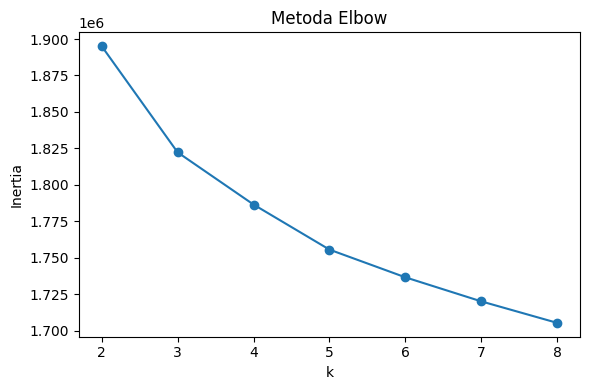

/tmp/ipykernel_48/3268104964.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("cluster")[[


         exam_score  previous_gpa  study_hours_per_day  sleep_hours  \
cluster                                                               
0             72.81          2.91                 2.93         6.67   
1             92.50          3.74                 5.73         7.05   
2             93.43          3.79                 4.17         7.02   
3             93.39          3.78                 3.46         7.27   

         motivation_level  exam_anxiety_score  
cluster                                        
0                    3.74                9.61  
1                    4.11                9.51  
2                    8.85                6.15  
3                    4.11                9.55  


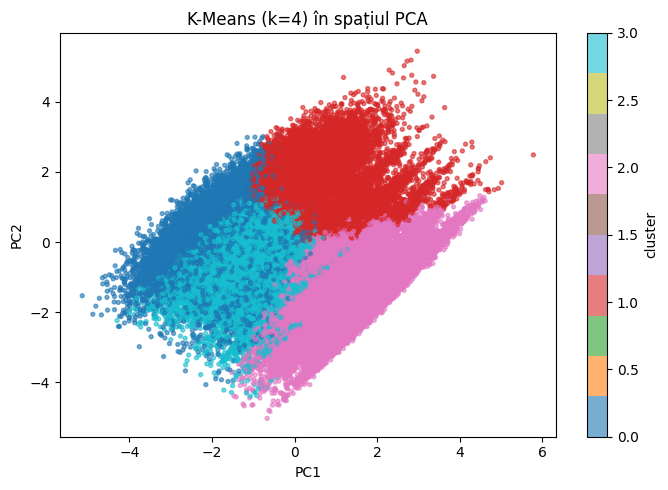

In [163]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


X_cluster = df.drop(columns=["exam_score", "dropout_risk"], errors="ignore")


num_cols_u = X_cluster.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_u = [c for c in X_cluster.columns if c not in num_cols_u]


num_pipe_u = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe_u = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_u = ColumnTransformer([
    ("num", num_pipe_u, num_cols_u),
    ("cat", cat_pipe_u, cat_cols_u)
])


X_u = preprocess_u.fit_transform(X_cluster)


inertia = []
K = range(2, 9)
for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_u)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, "o-")
plt.title("Metoda Elbow")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.tight_layout(); plt.show()


k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_u)


df["cluster"] = pd.Categorical(clusters)


summary = df.groupby("cluster")[[
    "exam_score", "previous_gpa", "study_hours_per_day",
    "sleep_hours", "motivation_level", "exam_anxiety_score"
]].mean().round(2)
print(summary)


pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_u)

plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1], c=clusters, cmap="tab10", alpha=0.6, s=8)
plt.title(f"K-Means (k={k}) în spațiul PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(label="cluster")
plt.tight_layout(); plt.show()

Cluster 0 → studenți cu performanță scăzută, anxietate ridicată -albastru

Cluster 1 → performanți și echilibrați - rosu

Cluster 2 → performanți și foarte motivați - mov

Cluster 3 → performanți, dar motivație scăzută și anxietate mare - turcoaz

# Model Retea Neuronala - MLP Regressor

1. Am ales MLPRegressor (Multi-layer Perceptron) deoarece Rețelele Neurale  sunt cele mai eficiente instrumente pentru a modela relațiile non-liniare și foarte complexe din setul de date.
2. Rețeaua Neuronală utilizează o arhitectură simplă, dar eficientă, cu două straturi ascunse (hidden\_layer\_sizes=(64, 32)).Primul strat (64 de neuroni) primieste inputul, iar stratul 2 (32 de neuroni) reduce dimensiunea informației, forțând rețeaua să păstreze doar cele mai relevante tipare învățate de primul strat.

In [164]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline


mlp_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',            
        solver='adam',               
        max_iter=300,                 
        random_state=42
    ))
])


mlp_reg.fit(X_train, y_train)


y_pred = mlp_reg.predict(X_test)


print("MLP Regression R²:", r2_score(y_test, y_pred))
print("MLP Regression MAE:", mean_absolute_error(y_test, y_pred))

MLP Regression R²: 0.8695503188011777
MLP Regression MAE: 3.293146189751912


Modelul MLPRegressor a obținut un scor R^2 de 0.8696 și o eroare MAE de 3.29. Performanța sa este aproape identică cu cea a modelului Random Forest si mai mica decat a modelului Ridge.Acest lucru confirmă o observație cheie în setul de date: valoarea predictivă a datelor este în principal liniară, iar complexitatea unei Rețele Neurale nu a reușit să îmbunătățească semnificativ precizia față de un algoritm de bază (Ridge).

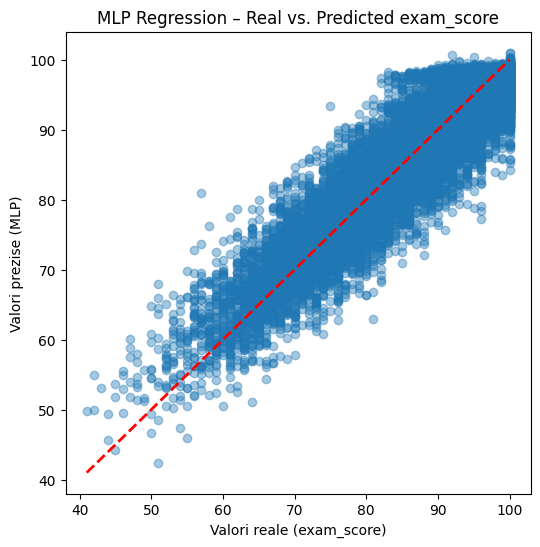

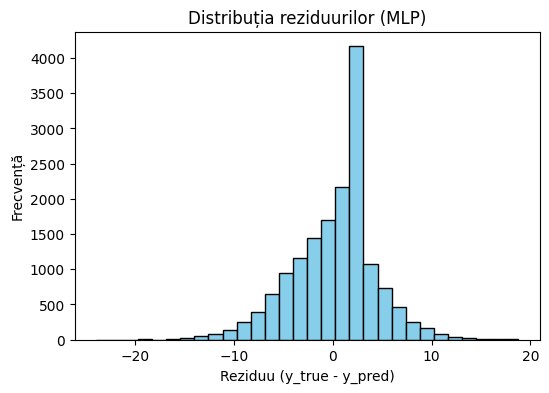

In [165]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Valori reale (exam_score)")
plt.ylabel("Valori prezise (MLP)")
plt.title("MLP Regression – Real vs. Predicted exam_score")
plt.show()


residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribuția reziduurilor (MLP)")
plt.xlabel("Reziduu (y_true - y_pred)")
plt.ylabel("Frecvență")
plt.show()

In [166]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = cross_val_score(mlp_reg, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)

print("MLP CV MAE (mean ± std):", -cv_mae.mean(), "±", cv_mae.std())

MLP CV MAE (mean ± std): 3.2470412129956463 ± 0.05208162420167782


1. Faptul că punctele sunt strâns grupate în jurul liniei diagonale ideale (unde Real = Prezis) indică faptul că modelul MLP a reușit să găsească o mapare precisă între caracteristicile de intrare și nota la examen.Distribuția uniformă în jurul liniei demonstrează că nu există un bias vizibil. Modelul nu supraestimează sau subestimează constant scorurile pe o anumită gamă de valori.

2. Vârful curbei se află la 0 pe axa Reziduurilor. Acest lucru este esențial și confirmă că modelul nu are erori sistematice (un bias constant de subestimare sau supraestimare). Forma îngustă și înaltă a curbei confirmă valoarea mică a MAE de 3.29. Aceasta înseamnă că marea majoritate a erorilor modelului (frecvența cea mai mare) sunt grupate foarte aproape de zero.

In [167]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = cross_val_score(mlp_reg, X, y, 
                         scoring="neg_mean_absolute_error", 
                         cv=cv, n_jobs=-1)

print("MLP CV MAE (mean ± std):", -cv_mae.mean(), "±", cv_mae.std())

MLP CV MAE (mean ± std): 3.2470412129956463 ± 0.05208162420167782


Deși modelul MLPRegressor a confirmat plafonul de performanță al setului de date, atingând o acuratețe similară (R^2 approx 0.86) cu modelul Random Forest, complexitatea sa sporită nu s-a tradus într-un avantaj major. Mai mult, datorită variabilității inerente a Rețelelor Neurale (cauzată de inițializarea aleatoare a ponderilor), MLP a demonstrat o stabilitate mai mică (deviație standard mai mare) în timpul Cross-Validation.

# Anomaly Detection – Isolation Forest

**Am ales Isolation Forest (IF), un algoritm de tip ansamblu bazat pe arbori, excelent pentru detectarea anomaliilor. IF funcționează pe principiul că anomaliile sunt puține și izolate; prin urmare, sunt mult mai ușor de separat de restul datelor (de "izolat") într-un arbore de decizie decât mostrele normale.**

    Modelul IF (ca și K-Means) funcționează cel mai bine pe date scalate. Am utilizat un Pipeline de preprocesare separat (preprocess_a) similar celui de la clustering:
* SimpleImputer pentru a trata valorile lipsă.
* StandardScaler a fost folosit pentru a uniformiza scalele, asigurând că distanța și izolarea sunt calculate echitabil pe toate dimensiunile.
* OneHotEncoder pentru a converti variabilele categorice în format numeric.

 n_estimators=200 - Reprezintă numărul de arbori construiți în pădure. Un număr mare (200) crește robustețea și reduce variația rezultatului final.
 contamination=0.02 - acesta este un hiperparametru cheie care specifică procentul așteptat de anomalii din setul de date. 
 .fit_transform - Această funcție returnează -1 pentru anomalii și +1 pentru mostre normale.

            exam_score  previous_gpa  study_hours_per_day  sleep_hours  \
is_outlier                                                               
0                89.33          3.61                 4.19         7.02   
1                80.13          3.23                 3.40         7.10   

            motivation_level  exam_anxiety_score  
is_outlier                                        
0                       5.48                8.52  
1                       5.85                7.95  


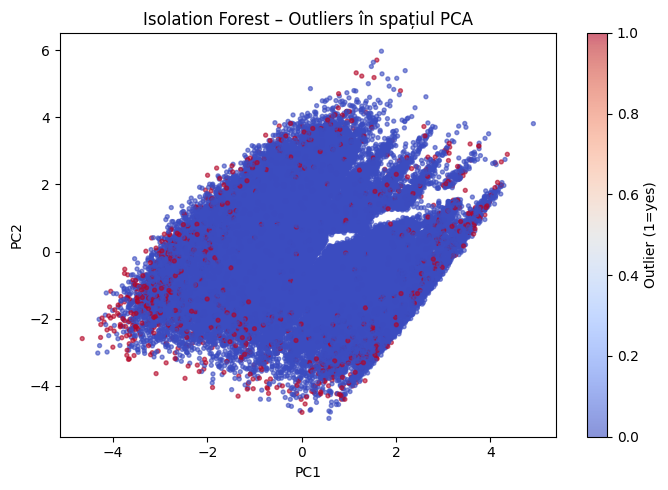

In [168]:
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X_anom = df.drop(columns=["exam_score", "dropout_risk"], errors="ignore")

num_cols_a = X_anom.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_a = [c for c in X_anom.columns if c not in num_cols_a]

num_pipe_a = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe_a = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_a = ColumnTransformer([
    ("num", num_pipe_a, num_cols_a),
    ("cat", cat_pipe_a, cat_cols_a)
])

X_a = preprocess_a.fit_transform(X_anom)

iso = IsolationForest(
    n_estimators=200,
    contamination=0.02,
    random_state=42
)

outlier_labels = iso.fit_predict(X_a)

df["is_outlier"] = (outlier_labels == -1).astype(int)

outlier_summary = df.groupby("is_outlier")[[
    "exam_score", "previous_gpa", "study_hours_per_day",
    "sleep_hours", "motivation_level", "exam_anxiety_score"
]].mean().round(2)

print(outlier_summary)

pca = PCA(n_components=2, random_state=42)
Z_anom = pca.fit_transform(X_a)

plt.figure(figsize=(7,5))
plt.scatter(Z_anom[:,0], Z_anom[:,1],
            c=df["is_outlier"], cmap="coolwarm", s=8, alpha=0.6)
plt.title("Isolation Forest – Outliers în spațiul PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(label="Outlier (1=yes)")
plt.tight_layout()
plt.show()

1. Pentru a vizualiza cele 2% de anomalii în spațiul înalt-dimensional, am folosit PCA (Analiza Componentelor Principale) pentru a proiecta datele pe două axe (PC1 și PC2).
2. Graficul Scatter Plot arată că punctele etichetate ca anomalii (cu roșu) sunt izolate în afara norului principal de date (punctele normale, în albastru). Această vizualizare justifică faptul că Isolation Forest a lucrat corect: anomaliile sunt, fizic, cele mai îndepărtate puncte de restul populației.